<a href="https://colab.research.google.com/github/PranavShashidhara/Country-Default-Prediction/blob/main/Matrix_factorization_in_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install keras

In [ ]:
pip install boto3

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
import boto3

In [ ]:
df = pd.read_parquet('https://netflix-project-data.s3.us-east-1.amazonaws.com/Preprocessed+data/small_filtered_data.parquet')
df.head()

,User_id,Movie_id,Ratings,Date,RemappedUserId
0,2456613,8,3,2004-03-31,292668
1,1979083,8,2,2004-05-12,196704
2,1391523,8,3,2004-04-27,78623
3,1744889,8,1,2005-08-25,149742
4,995497,8,2,2005-02-14,479264


In [ ]:
df['User_id'] = df['User_id'].astype('str')
N = df['User_id'].astype(int).max() + 1 # number of users
M = df['Movie_id'].astype(int).max() + 1# number of movies

In [ ]:
df = shuffle(df)

In [ ]:
cutoff = int(0.8*len(df))
df_train = df[:cutoff]
df_test = df[cutoff:]

In [ ]:
df_train['Ratings'] = df_train['Ratings'].astype(float)
df_test['Ratings'] = df_test['Ratings'].astype(float)

<ipython-input-16-8153112fe6ae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Ratings'] = df_train['Ratings'].astype(float)
<ipython-input-16-8153112fe6ae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Ratings'] = df_test['Ratings'].astype(float)


In [ ]:
mu = df_train.Ratings.mean()

In [ ]:
K = 10
epochs = 10
reg = 0.1

In [ ]:
U = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(U)# output as (N, 1, K) this is to take into account any sequences which are present
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m) # output as (N, 1, K)

u_bias = Embedding(N, 1, embeddings_regularizer=l2(reg))(U) # (N, 1, 1)
m_bias = Embedding(M, 1, embeddings_regularizer=l2(reg))(m) # (N, 1, 1)
x = Dot(axes=2)([u_embedding, m_embedding])
x = Add()([x, u_bias, m_bias])
x = Flatten()(x) #(N, 1)

In [ ]:
model = Model(inputs=[U,m], outputs=x) # inputs user and movie and one output X
model.compile(
    loss='mse',
    optimizer=SGD(),
    metrics=['mse']# why mse twice? one is for regularized loss and the other is the normal mse.
)

df_train['User_id_num'] = pd.factorize(df_train['User_id'])[0]
df_train['Movie_id_num'] = pd.factorize(df_train['Movie_id'])[0]

df_test['User_id_num'] = pd.factorize(df_test['User_id'])[0]
df_test['Movie_id_num'] = pd.factorize(df_test['Movie_id'])[0]

r = model.fit(
    x=[df_train['User_id_num'].values, df_train['Movie_id_num'].values],
    y=df_train.Ratings.values - mu,
    epochs = epochs,
    batch_size=128,
    validation_data=([df_test.User_id_num.values, df_test.Movie_id_num.values],
                     df_test.Ratings.values - mu)
)


<ipython-input-33-43d7ccfa1710>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['User_id_num'] = pd.factorize(df_train['User_id'])[0]
<ipython-input-33-43d7ccfa1710>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Movie_id_num'] = pd.factorize(df_train['Movie_id'])[0]
<ipython-input-33-43d7ccfa1710>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

Epoch 1/10
58488/58488 ━━━━━━━━━━━━━━━━━━━━ 289s 5ms/step - loss: 64.1988 - mse: 1.1251 - val_loss: 1.1277 - val_mse: 1.1267
Epoch 2/10
58488/58488 ━━━━━━━━━━━━━━━━━━━━ 338s 5ms/step - loss: 1.1254 - mse: 1.1245 - val_loss: 1.1277 - val_mse: 1.1267
Epoch 3/10
58488/58488 ━━━━━━━━━━━━━━━━━━━━ 306s 5ms/step - loss: 1.1261 - mse: 1.1251 - val_loss: 1.1277 - val_mse: 1.1267
Epoch 4/10
58488/58488 ━━━━━━━━━━━━━━━━━━━━ 302s 5ms/step - loss: 1.1263 - mse: 1.1253 - val_loss: 1.1277 - val_mse: 1.1267
Epoch 5/10
58488/58488 ━━━━━━━━━━━━━━━━━━━━ 287s 5ms/step - loss: 1.1256 - mse: 1.1246 - val_loss: 1.1276 - val_mse: 1.1267
Epoch 6/10
58488/58488 ━━━━━━━━━━━━━━━━━━━━ 321s 5ms/step - loss: 1.1261 - mse: 1.1252 - val_loss: 1.1277 - val_mse: 1.1267
Epoch 7/10
58488/58488 ━━━━━━━━━━━━━━━━━━━━ 321s 5ms/step - loss: 1.1250 - mse: 1.1241 - val_loss: 1.1276 - val_mse: 1.1267
Epoch 8/10
58488/58488 ━━━━━━━━━━━━━━━━━━━━ 340s 5ms/step - loss: 1.1250 - mse: 1.1241 - val_loss: 1.1277 - val_mse: 1.1267
Epoch 9

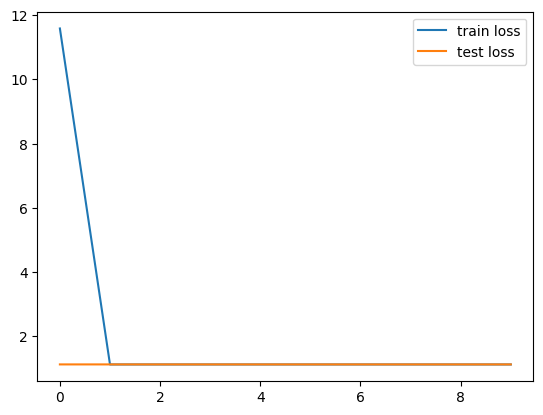

In [ ]:
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()
